In [251]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import expm
from scipy.stats import norm
from scipy.stats import lognorm

# To store the face history values 

Face_history_bottom = [ ]
Face_history_top = [ ]
Face_history_constant_H = [ ]

# To store the initial angular velocities

omega_list = [ ]

H_0_list = np.linspace(0.00001, 0.152, 40)
distance_from_edge_list = np.linspace(0.00001, 0.114, 40) 


# ------------------ Record the face for each point -------------------

face_1_history_track = [ ]
face_2_history_track = [ ]
face_3_history_track = [ ]
face_4_history_track = [ ]
face_5_history_track = [ ]
face_6_history_track = [ ]
standard_deviation_list = [ ]

N = 20

In [253]:
for H_0 in H_0_list:
    for distance_from_edge in distance_from_edge_list:

        # ----- initilization of the face history matrices ------ 
        
        face_1_history = [ ]
        face_2_history = [ ]
        face_3_history = [ ]
        face_4_history = [ ]
        face_5_history = [ ]
        face_6_history = [ ]
        
        for j in range(N):
            
            print("For height", H_0, "and distance from edge", distance_from_edge)

            # Constants
            g = 9.81
            dt = 0.001
            mass = 0.016
            edge_length = 0.019
            restitution = lognorm.rvs(0.04, scale = 0.15)
            max_bounces = 20 
            gamma = 1 / 6
            I = (1 / 6) * mass * edge_length**2

            # Initial state
            alpha = np.pi*(norm.rvs(loc = 15, scale = 0.5))/180
        
            v = np.sqrt(2 * g * (distance_from_edge / np.sin(alpha)))

            pos = np.array([0.0, 0.0, H_0])
            vel = np.array([v*np.cos(alpha) , 0.0, -v*np.sin(alpha)])

            omega = (g / v) * (
                0.5 * np.cos(alpha) * math.log((2 / 3) / (5 / 12 + (np.tan(alpha)) ** 2)) +
                0.775 * np.sin(alpha) * (37.76 - math.atan(0.775 * np.tan(alpha)))
            )

            angular_velocity = np.array([0, omega, 0])

            def euler_to_rotmat(roll, pitch, yaw):
                cy, sy = np.cos(yaw), np.sin(yaw)
                cp, sp = np.cos(pitch), np.sin(pitch)
                cr, sr = np.cos(roll), np.sin(roll)
                return np.array([
                    [cy * cp, cy * sp * sr + sy * cr, -cy * sp * cr + sy * sr],
                    [-sy * cp, -sy * sp * sr + cy * cr, sy * sp * cr + cy * sr],
                    [sp, -cp * sr, cp * cr]
                ]).T

            # Initial rotation matrix (identity)
            z_rotation_initial = norm.rvs(loc = 0, scale = 0.1)
            rotation_matrix = euler_to_rotmat(0, alpha, z_rotation_initial)

            # Local face normals and cube vertices
            face_normals_local = np.array([
                [0, 0, 1],
                [0, 0, -1],
                [1, 0, 0],
                [-1, 0, 0],
                [0, 1, 0],
                [0, -1, 0],
            ])

            vertex = (edge_length / 2) * np.array([
                [1, 1, -1], [1, -1, -1], [-1, -1, -1], [-1, 1, -1],
                [1, 1, 1], [1, -1, 1], [-1, -1, 1], [-1, 1, 1]
            ])

            bounces = 0
            gravity = np.array([0, 0, -g])

            while bounces < max_bounces:
                # Update rotation matrix
                omega_cross = np.array([
                    [0, -angular_velocity[2], angular_velocity[1]],
                    [angular_velocity[2], 0, -angular_velocity[0]],
                    [-angular_velocity[1], angular_velocity[0], 0]
                ])
            
                rotation_matrix = expm(omega_cross * dt) @ rotation_matrix

                # Rotate vertices
                vertex_final = (rotation_matrix @ vertex.T).T

                dot_products_vertex_final = vertex_final @ gravity.T
                lowest_vertex = vertex_final[np.argmax(dot_products_vertex_final)]

                # Update position and velocity
                vel[2] -= g * dt
                pos = pos + vel * dt + 0.5 * gravity * dt**2

                z_hat = np.array([0, 0, 1])
            
                if ((lowest_vertex + pos) @ z_hat.T) <= 0:
                    pos[2] = -lowest_vertex[2] 

                    r_hat = lowest_vertex
                    x, y, z = r_hat[0], r_hat[1], r_hat[2]

                    restitution_matrix = np.array([[0, 0, 0], [0, 0, 0], [0, 0, -restitution - 1]])

                    rotation_tensor = np.array([
                        [gamma * edge_length**2 + y**2 + z**2, -x * y, -x * z],
                        [-x * y, gamma * edge_length**2 + x**2 + z**2, -y * z],
                        [-x * z, -y * z, gamma * edge_length**2 + x**2 + y**2]
                    ])

                    Impulse = I * np.linalg.inv(rotation_tensor) @ (restitution_matrix @ (vel + np.cross(angular_velocity, r_hat)).T)

                    angular_velocity += (1 / I) * np.cross(r_hat, Impulse)
                    vel += Impulse / mass

                    bounces += 1


            face_normals_world = (rotation_matrix @ face_normals_local.T).T
            dot_products = face_normals_world @ gravity.T
            bottom_face_index = np.argmax(dot_products)
            bottom_face_normal = face_normals_world[bottom_face_index]

            top_face_index = 7 - (bottom_face_index + 1)
            face_map = {1: 6, 2: 1, 3: 5, 4: 2, 5: 3, 6: 4}
            top_face_index = face_map.get(top_face_index, top_face_index)

            if top_face_index == 1:
                face_1_history.append(top_face_index)
            if top_face_index == 2:
                face_2_history.append(top_face_index)
            if top_face_index == 3:
                face_3_history.append(top_face_index)
            if top_face_index == 4:
                face_4_history.append(top_face_index)
            if top_face_index == 5:
                face_5_history.append(top_face_index)
            if top_face_index == 6:
                face_6_history.append(top_face_index)

        print("face 1 probability", len(face_1_history)/N)
        face_1_history_track.append(len(face_1_history)/N)
        print("face 2 probability", len(face_2_history)/N)
        face_2_history_track.append(len(face_2_history)/N)
        print("face 3 probability", len(face_3_history)/N)
        face_3_history_track.append(len(face_3_history)/N)
        print("face 4 probability", len(face_4_history)/N)
        face_4_history_track.append(len(face_4_history)/N)
        print("face 5 probability", len(face_5_history)/N)
        face_5_history_track.append(len(face_5_history)/N)
        print("face 6 probability", len(face_6_history)/N)
        face_6_history_track.append(len(face_6_history)/N)

        # Standard deviation of the 6 probabilities

        standard_deviation = np.std([len(face_1_history)/N, len(face_2_history)/N, 
                                    len(face_3_history)/N, len(face_4_history)/N,
                                    len(face_5_history)/N, len(face_6_history)/N])
        
        standard_deviation_list.append(standard_deviation)
        print("standard_deviation", standard_deviation)

For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
For height 1e-05 and distance from edge 1e-05
face 1 probability 0.1
face 2 probability 0.2
face 3 probability 0.2
face 4 probability 0.2
face 5 probability 0.3
face 6 probability 0.0
standard_deviation 0.09428090415820634
For height 1e-05 and distance from edge 0.0039406896551724135
For height 1e-05 and distance from edge 0.0039406896551724135
For height 1e-05 and distance from edge 0.0039406896551724135
For height 1e-05 and distance from edge 0.0039406896551724135
For height 1e-05 and distance from edge 0.0039406896551724135
For height 1e-05 and distance from edge 0.00394068965

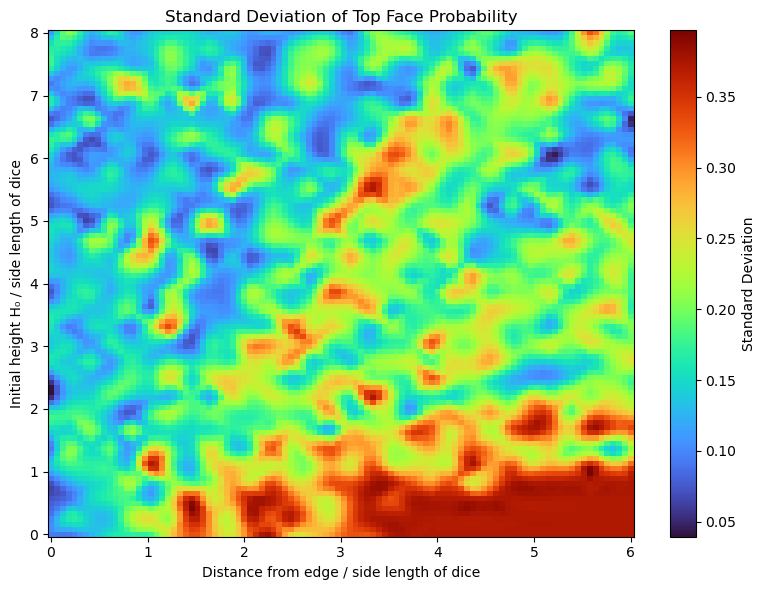

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Create mesh and flatten
distance_grid, H_0_grid = np.meshgrid(distance_from_edge_list, H_0_list)
distance_flat = distance_grid.flatten() / edge_length
H_0_flat = H_0_grid.flatten() / edge_length

# Standard deviation data (same shape as flattened distance/H_0)
Face_history_top = np.array(Face_history_top)
std_flat = np.array(standard_deviation_list)

# Create smooth interpolation grid
xi = np.linspace(distance_flat.min(), distance_flat.max(), 100)
yi = np.linspace(H_0_flat.min(), H_0_flat.max(), 100)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate standard deviation onto a grid
zi = griddata((distance_flat, H_0_flat), std_flat, (xi_grid, yi_grid), method='cubic')

# Plot
plt.figure(figsize=(8,6))
c = plt.pcolormesh(xi_grid, yi_grid, zi, shading='auto', cmap='turbo')
plt.colorbar(c, label='Standard Deviation')
plt.xlabel('Distance from edge / side length of dice')
plt.ylabel('Initial height H₀ / side length of dice')
plt.title('Standard Deviation of Top Face Probability')
plt.tight_layout()
plt.show()


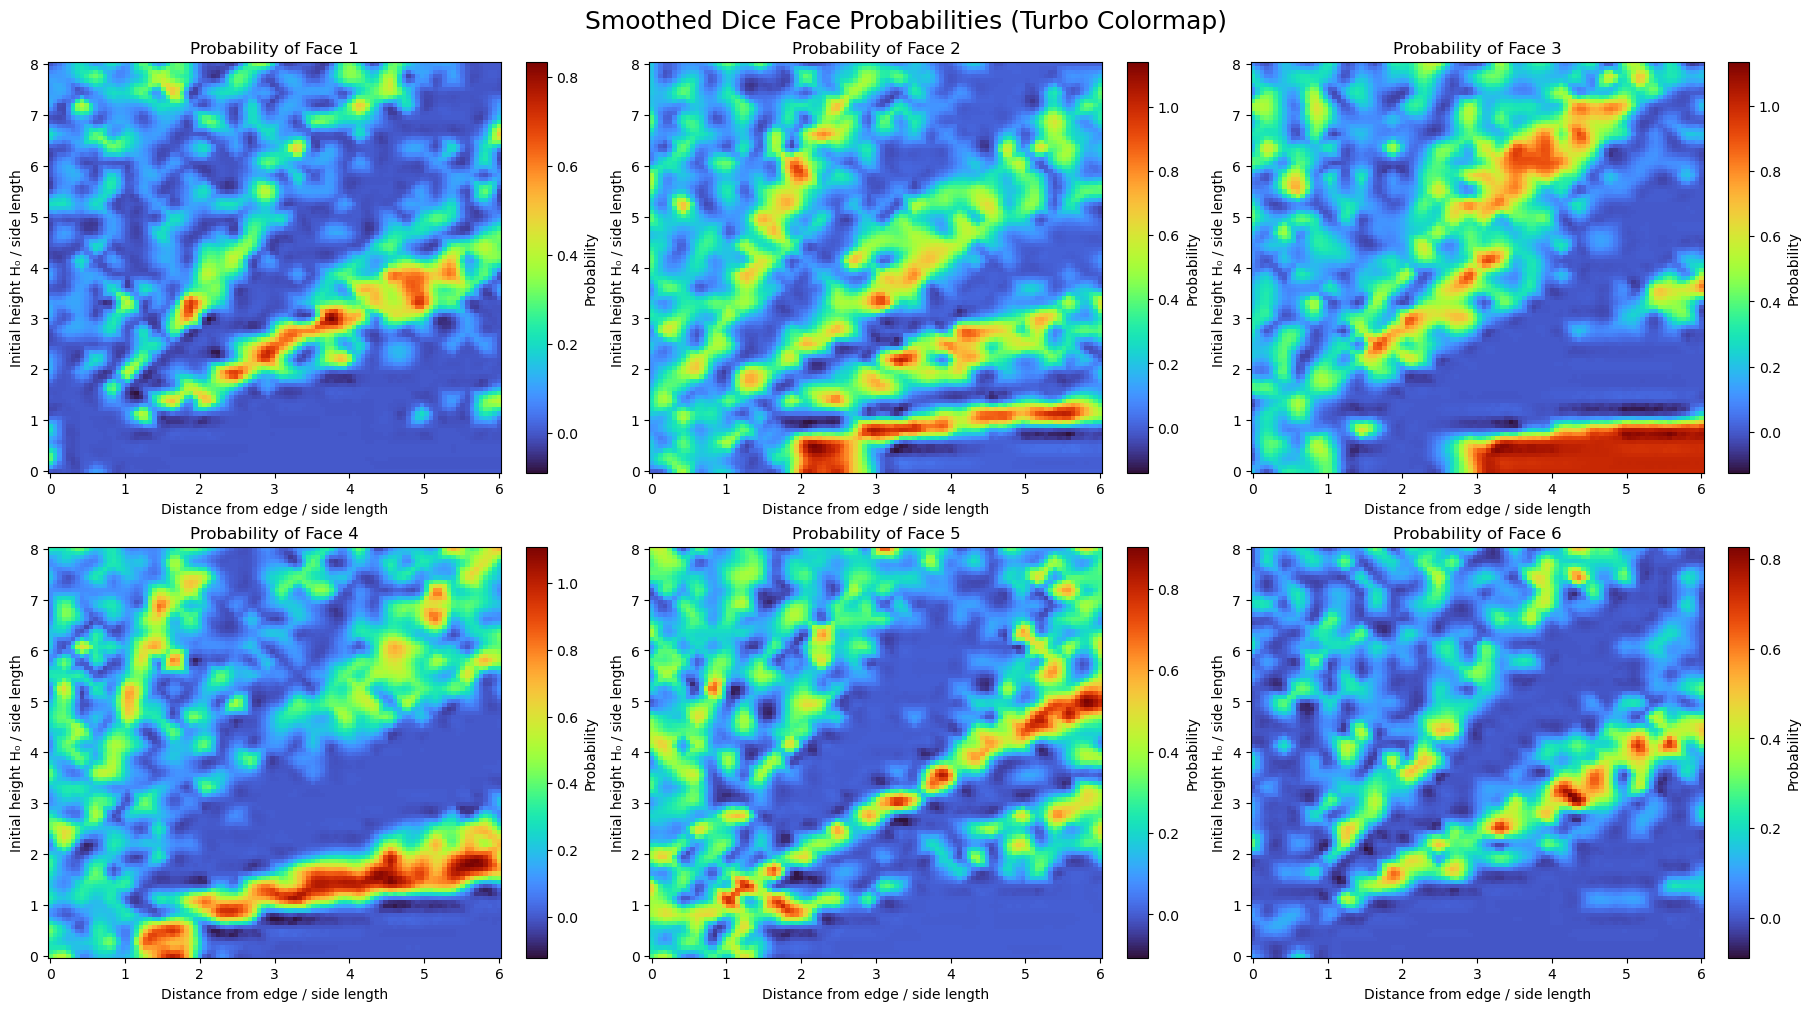

In [229]:
# ------- six individual graphs for different faces ------- #

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Flatten and normalize grids
distance_flat = distance_grid.flatten() / edge_length
H_0_flat = H_0_grid.flatten() / edge_length

# Define smoothed interpolation grid
xi = np.linspace(distance_flat.min(), distance_flat.max(), 100)
yi = np.linspace(H_0_flat.min(), H_0_flat.max(), 100)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# List of all face probability arrays
faces = [
    np.array(face_1_history_track),
    np.array(face_2_history_track),
    np.array(face_3_history_track),
    np.array(face_4_history_track),
    np.array(face_5_history_track),
    np.array(face_6_history_track)
]

# Use the 'turbo' colormap for all subplots
colormap = 'turbo'

# Create 2x3 plot layout
fig, axs = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

for i, (ax, face_data) in enumerate(zip(axs.flat, faces), start=1):
    # Interpolate the data to a regular grid for smooth coloring
    zi = griddata((distance_flat, H_0_flat), face_data, (xi_grid, yi_grid), method='cubic')

    # Plot the smooth data with the turbo colormap
    pcm = ax.pcolormesh(xi_grid, yi_grid, zi, shading='auto', cmap=colormap)
    ax.set_title(f'Probability of Face {i}')
    ax.set_xlabel('Distance from edge / side length')
    ax.set_ylabel('Initial height H₀ / side length')

    # Add colorbar for each subplot
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('Probability')

# Add a super title for the entire figure
plt.suptitle('Smoothed Dice Face Probabilities (Turbo Colormap)', fontsize=18)
plt.show()


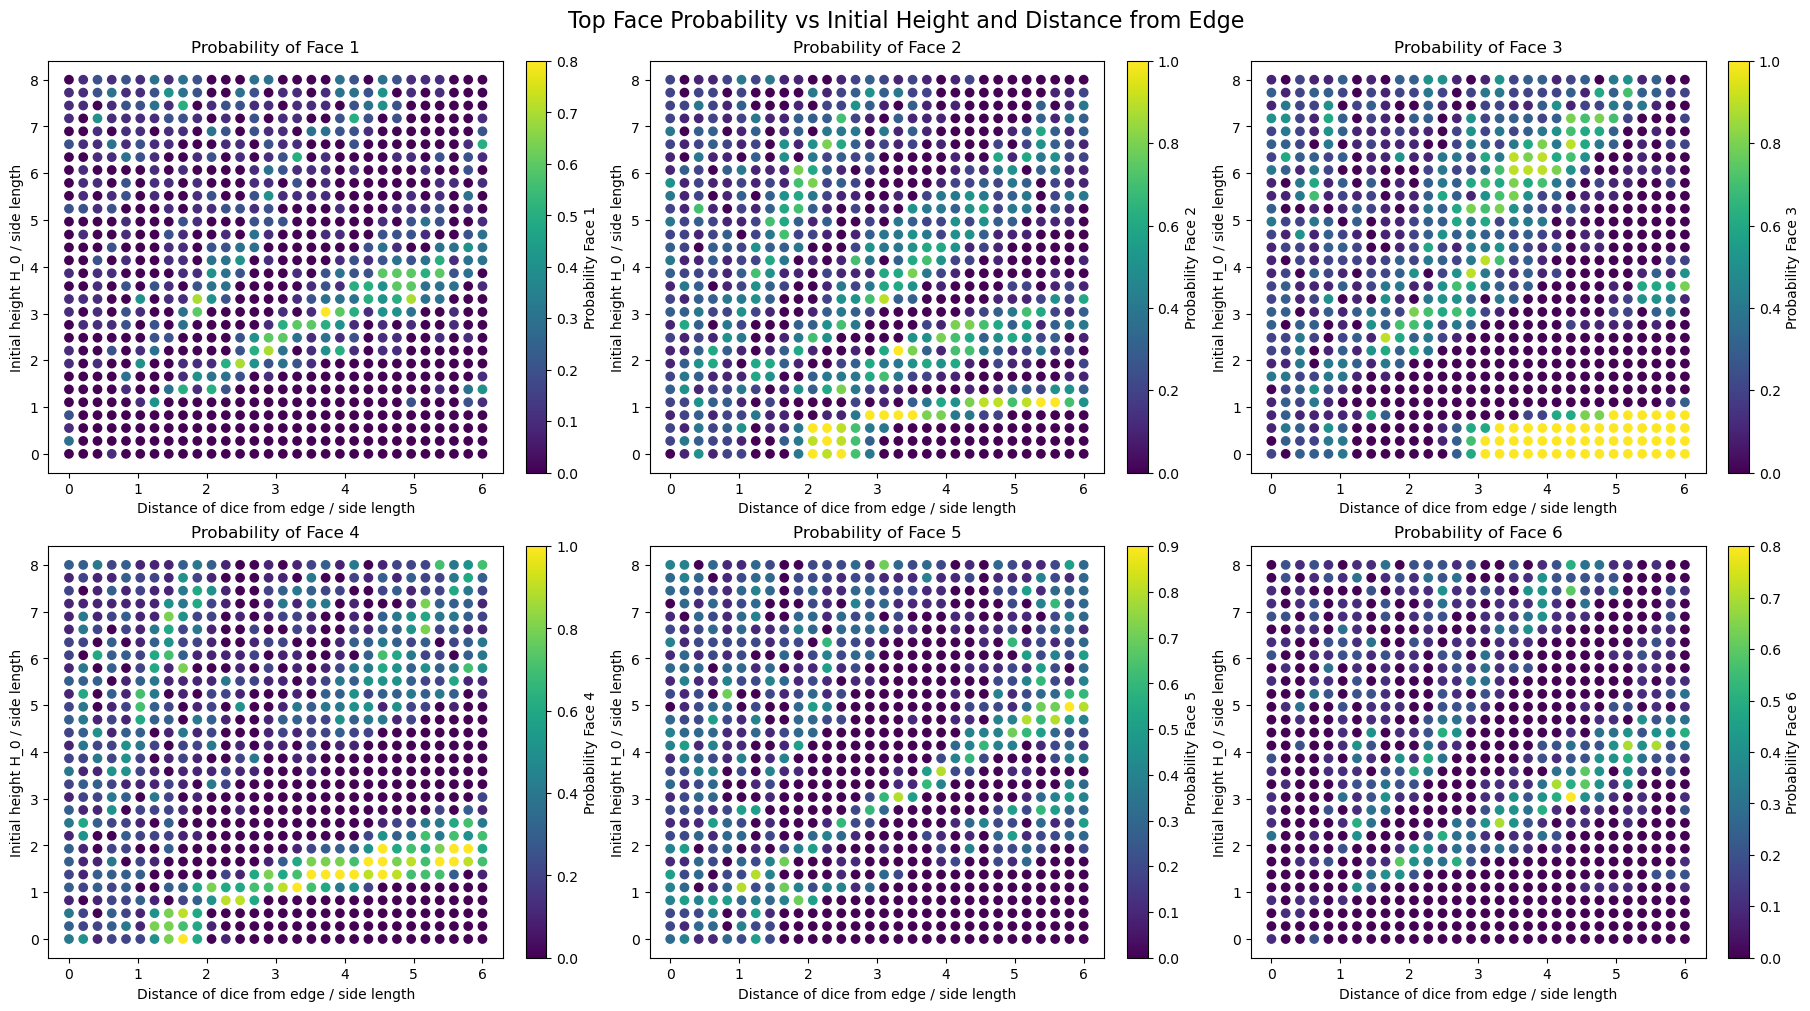

In [233]:
# Flatten and normalize grids
distance_flat = distance_grid.flatten() / edge_length
H_0_flat = H_0_grid.flatten() / edge_length

# Convert all face history tracks to numpy arrays
faces = [
    np.array(face_1_history_track),
    np.array(face_2_history_track),
    np.array(face_3_history_track),
    np.array(face_4_history_track),
    np.array(face_5_history_track),
    np.array(face_6_history_track)
]

fig, axs = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

for i, ax in enumerate(axs.flat, start=1):
    scatter = ax.scatter(distance_flat, H_0_flat, c=faces[i-1], cmap='viridis')
    ax.set_title(f'Probability of Face {i}')
    ax.set_xlabel('Distance of dice from edge / side length')
    ax.set_ylabel('Initial height H_0 / side length')
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label(f'Probability Face {i}')

plt.suptitle('Top Face Probability vs Initial Height and Distance from Edge', fontsize=16)
plt.show()

In [ ]:
# Combining into a single plot using standard deviation

